###Importing Data

In [ ]:
import torch
device="cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader

from sklearn.model_selection import train_test_split

In [ ]:
from google.colab import drive
drive.mount("/content/drive")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd

TRAIN_CSV_PATH = "/content/drive/MyDrive/datasets/Train.csv"
data = pd.read_csv(TRAIN_CSV_PATH)

data.head()


,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


###Data processing and transform

In [ ]:
def display_image(data,index):
  label=data.iloc[index,0]
  pixel=data.iloc[index,1:].values.astype(np.uint8)
  image=pixel.reshape(28,28)

  plt.imshow(image,cmap="gray")
  plt.title(f"{label}\n{image.shape}")
  plt.axis("off")
  plt.show()

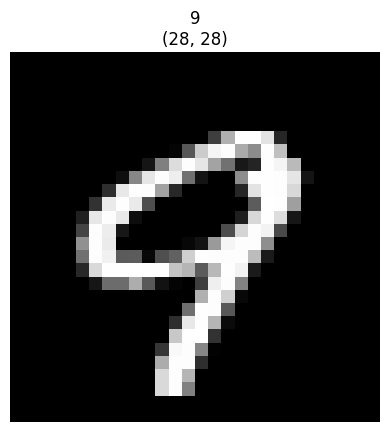

In [ ]:
display_image(data,100)

###1️⃣ Split features & labels

In [ ]:
x=data.iloc[:,1:].values
y=data.iloc[:,0].values

###2️⃣ Train–test split

In [ ]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=42,stratify=y)


In [ ]:
print(type(x_train))
print(type(y_train))


<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


###3️⃣ Convert to PyTorch tensors

In [ ]:
x_train=torch.tensor(x_train,dtype=torch.float32)
x_test=torch.tensor(x_test,dtype=torch.float32)
y_train=torch.tensor(y_train,dtype=torch.long)
y_test=torch.tensor(y_test,dtype=torch.long)

###4️⃣ Normalize pixel values

In [ ]:
x_train=x_train.view(-1,1,28,28)
X_test=x_test.view(-1,1,28,28)


In [ ]:
from torch.utils.data import Dataset

class MNISTCSV(Dataset):
  def __init__(self,X,y,transform=None):
    self.X=X
    self.y=y
    self.transform=transform
  def __len__(self):
    return len(self.X)
  def __getitem__(self, idx):
    image = self.X[idx].reshape(28, 28)
    label = self.y[idx]

    if self.transform:
        image = self.transform(image)

    label = torch.tensor(label, dtype=torch.long)

    return image, label



In [ ]:
from torchvision import transforms

transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,),(0.5,))
])

In [ ]:
train_dataset=MNISTCSV(x_train.numpy(),y_train.numpy(),transform=transform)
test_dataset=MNISTCSV(x_test.numpy(),y_test.numpy(),transform=transform)

train_loader=train_loader = DataLoader(
    train_dataset,
    batch_size=64,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)

test_loader=DataLoader(test_dataset,batch_size=654,shuffle=False)

In [ ]:
class CNNModel(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()

        self.block1 = nn.Sequential(
            nn.Conv2d(input_shape, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.block2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(hidden_units * 7 * 7, output_shape)
        )

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.classifier(x)
        return x


In [ ]:
model=CNNModel(input_shape=1,
               hidden_units=32,
               output_shape=len(np.unique(y)))

In [ ]:
model

CNNModel(
  (block1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block2): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1568, out_features=10, bias=True)
  )
)

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [ ]:
images, labels = next(iter(train_loader))
print(images.shape)


torch.Size([64, 1, 28, 28])


In [ ]:
def accuracy_fn(y_true, y_pred):
    y_pred_class = torch.argmax(y_pred, dim=1)
    correct = (y_pred_class == y_true).sum().item()
    acc = (correct / len(y_true)) * 100
    return acc


In [ ]:
from timeit import default_timer as timer
def print_train_time(start:float,end:float,device=torch.device):
  time=end-start
  print(f"Train time on {device}: {time:.3f} seconds")
  return time

In [ ]:
def train(model:torch.nn.Module,
          dataset:torch.utils.data.DataLoader,
          loss_fn:torch.nn.Module,
          optimizer:torch.optim.Optimizer,
          accuracy_fn,
          device=device):
  train_loss,train_acc=0,0
  model.to(device)
  model.train()
  for x,y in train_loader:
    x, y = x.to(device), y.to(device)
    y_pred=model(x)
    loss=loss_fn(y_pred,y)
    train_loss+=loss
    train_acc+=accuracy_fn(y_true=y,y_pred=y_pred)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  train_loss/=len(train_loader)
  train_acc/=len(train_loader)
  print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")
def test(model:torch.nn.Module,
         dataset:torch.utils.data.DataLoader,
         loss_fn:torch.nn.Module,
         accuracy_fn,
         device=device):
  test_loss,test_acc=0,0
  model.to(device)
  model.eval()
  with torch.inference_mode():
    for x,y in test_loader:
      x, y = x.to(device), y.to(device)
      test_pred=model(x)
      loss=loss_fn(test_pred,y)
      test_loss+=loss
      test_acc+=accuracy_fn(y_true=y,y_pred=test_pred)
    test_loss/=len(test_loader)
    test_acc/=len(test_loader)
    print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%\n")



In [ ]:
from tqdm import tqdm

In [ ]:
X, y = next(iter(train_loader))
print(y.dtype)


torch.int64


In [ ]:
torch.manual_seed(42)
from timeit import default_timer as timer
train_time_start=timer()

epochs = 10
for epoch in range(epochs):
  print(f"Epoch {epoch+1}:\n")
  train(model=model,
        dataset=train_loader,
        loss_fn=loss_fn,
        optimizer=optimizer,
        accuracy_fn=accuracy_fn,
        device=device)
  test(model=model,
       dataset=test_loader,
       loss_fn=loss_fn,
       accuracy_fn=accuracy_fn,
       device=device)
  train_time_end=timer()
print(f"Train time on {device}: {train_time_end - train_time_start:.3f} seconds")


Epoch 1:

Train loss: 0.18867 | Train accuracy: 94.45%
Test loss: 0.06574 | Test accuracy: 97.83%

Epoch 2:

Train loss: 0.05457 | Train accuracy: 98.36%
Test loss: 0.05128 | Test accuracy: 98.32%

Epoch 3:

Train loss: 0.04391 | Train accuracy: 98.67%
Test loss: 0.04808 | Test accuracy: 98.52%

Epoch 4:

Train loss: 0.03147 | Train accuracy: 98.96%
Test loss: 0.04970 | Test accuracy: 98.59%

Epoch 5:

Train loss: 0.02888 | Train accuracy: 99.08%
Test loss: 0.04886 | Test accuracy: 98.64%

Epoch 6:

Train loss: 0.02829 | Train accuracy: 99.09%
Test loss: 0.05899 | Test accuracy: 98.49%

Epoch 7:

Train loss: 0.02584 | Train accuracy: 99.13%
Test loss: 0.06353 | Test accuracy: 98.20%

Epoch 8:

Train loss: 0.02039 | Train accuracy: 99.36%
Test loss: 0.05216 | Test accuracy: 98.67%

Epoch 9:

Train loss: 0.02165 | Train accuracy: 99.27%
Test loss: 0.05998 | Test accuracy: 98.59%

Epoch 10:

Train loss: 0.01727 | Train accuracy: 99.41%
Test loss: 0.06937 | Test accuracy: 98.71%

Train tim

In [ ]:
def make_predictions(model, data, device=device):
    model.eval()
    all_preds = []

    with torch.inference_mode():
        for sample in data:
            # Prepare sample
            sample = sample.unsqueeze(0).to(device)   # (1, 1, 28, 28)

            # Forward pass
            logits = model(sample)                     # (1, 10)

            # Convert logits -> probabilities
            probs = torch.softmax(logits, dim=1)      # (1, 10)

            # Predicted class
            pred_class = torch.argmax(probs, dim=1).item()

            all_preds.append((pred_class, probs.cpu().squeeze()))

    return all_preds


In [ ]:
class_names = [str(i) for i in range(10)]


In [ ]:
import random
random.seed(42)

indices=random.sample(range(len(test_loader)),k=9)

test_samples=[test_dataset[i][0] for i in indices]
test_labels=[test_dataset[i][1] for i in indices]

print(f"Test sample image shape:{test_samples[0].shape}\n")
print(f"Test sample label:{test_labels[0]}({class_names[test_labels[0]]})")


Test sample image shape:torch.Size([1, 28, 28])

Test sample label:8(8)


In [ ]:
preds = make_predictions(
    model=model,
    data=test_samples   # ✅ list of images
)
preds[:5]

[(8,
  tensor([7.9316e-16, 9.2159e-18, 2.4887e-13, 9.6039e-14, 1.2457e-16, 5.3224e-15,
          4.0345e-17, 8.6917e-21, 1.0000e+00, 5.3999e-10])),
 (8,
  tensor([1.4360e-11, 5.1508e-12, 3.4589e-11, 5.9825e-11, 1.6911e-14, 1.2415e-10,
          1.2232e-11, 2.9445e-16, 1.0000e+00, 1.6145e-11])),
 (1,
  tensor([3.9813e-09, 1.0000e+00, 2.1067e-12, 3.4223e-17, 2.5522e-09, 1.1209e-13,
          5.7573e-09, 1.9772e-09, 3.0588e-09, 8.4648e-12])),
 (5,
  tensor([4.6839e-20, 5.8140e-17, 2.4604e-20, 1.1887e-12, 7.8806e-16, 1.0000e+00,
          4.7798e-20, 7.3950e-20, 4.3311e-10, 2.8921e-11])),
 (8,
  tensor([3.4262e-12, 1.9934e-07, 6.7829e-12, 1.3496e-10, 2.6259e-05, 4.9387e-11,
          3.7078e-16, 8.1556e-10, 9.9547e-01, 4.5005e-03]))]

In [ ]:
pred_classes=[pred[0] for pred in preds]
pred_classes


[8, 8, 1, 5, 8, 7, 8, 7, 4]

In [ ]:
test_labels,pred_classes

([tensor(8),
  tensor(8),
  tensor(1),
  tensor(5),
  tensor(9),
  tensor(7),
  tensor(8),
  tensor(7),
  tensor(4)],
 [8, 8, 1, 5, 8, 7, 8, 7, 4])

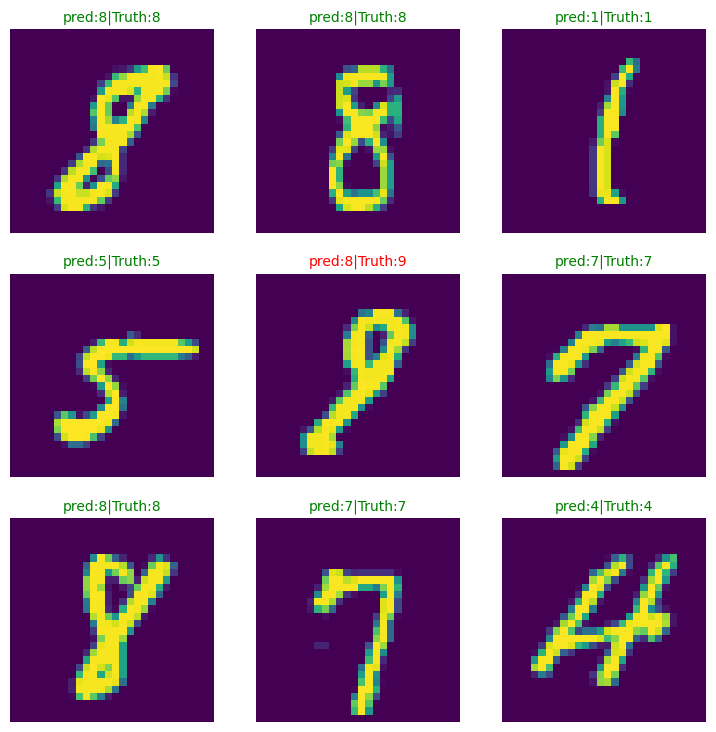

In [ ]:
plt.figure(figsize=(9,9))
nrows=3
ncols=3
for i,sample in enumerate(test_samples):
  plt.subplot(nrows,ncols,i+1)
  plt.imshow(sample.squeeze())
  pred_label=class_names[pred_classes[i]]
  truth_label=class_names[test_labels[i]]
  title_text=f"pred:{pred_label}|Truth:{truth_label}"
  if pred_label==truth_label:
    plt.title(title_text, fontsize=10, c="g") # green text if correct
  else:
      plt.title(title_text, fontsize=10, c="r") # red text if wrong
  plt.axis(False);

In [ ]:
from tqdm.auto import tqdm
y_preds=[]
model.eval()
with torch.inference_mode():
  for X,y in tqdm(test_loader,desc="Making predictions"):
    X,y=X.to(device),y.to(device)
    y_logit=model(X)
    y_pred=torch.softmax(y_logit,dim=1).argmax(dim=1)
    y_preds.append(y_pred.cpu())
y_pred_tensor=torch.cat(y_preds)

Making predictions:   0%|          | 0/13 [00:00<?, ?it/s]

In [ ]:
!pip install -q torchmetrics


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 53.2 MB/s eta 0:00:00


In [ ]:
from torchmetrics import ConfusionMatrix

model.eval()
all_preds = []
all_targets = []

with torch.inference_mode():
    for X, y in test_loader:
        X, y = X.to(device), y.to(device)

        logits = model(X)
        preds = torch.argmax(logits, dim=1)

        all_preds.append(preds.cpu())
        all_targets.append(y.cpu())

y_pred_tensor = torch.cat(all_preds)
y_true_tensor = torch.cat(all_targets)


ModuleNotFoundError: No module named 'torchmetrics'

In [ ]:
confmat = ConfusionMatrix(
    num_classes=len(class_names),
    task="multiclass"
)

confmat_tensor = confmat(
    preds=y_pred_tensor,
    target=y_true_tensor
)


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

cm = confmat_tensor.numpy()

plt.figure(figsize=(8, 6))
plt.imshow(cm, cmap="Blues")
plt.title("Confusion Matrix")
plt.colorbar()

tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)

thresh = cm.max() / 2
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(
            j, i, cm[i, j],
            ha="center",
            va="center",
            color="white" if cm[i, j] > thresh else "black"
        )

plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.tight_layout()
plt.show()


In [ ]:
torch.save(model.state_dict(), "cnn_mnist.pth")
